In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import grad, jit, vmap
from jax import random
from jax import jacfwd
import jax_cosmo as jc
import numpy
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import exponnorm
import sncosmo

In [2]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_debug_nans", True)

# Calculate the Fisher Matrix of SN programs

The data are m and measurement uncertainty dm

The model parameters are

Omega: Cosmological
c: calibration
Av, Rv: per supernova dust

The likelihood p(y| Omega, c, Av, Rv) is
N(c,dc) P(Av, Rv) Prod_SN N(m-(M+mu+C(c)+D(Av, Rv), dm_I^2 + dm^2)

The terms are
<partial ^2 lnL / partial alpha partial beta> = -partial X / partial alpha C^{-1} partial X /beta + delta_alpha,beta d2(ln p_alpha)


In [3]:
# Standard candle spectrum convolved with a nominal logarithmic filter
@jit
def M_sn(wl):
    wl0=5500.
    sig2 = 5e6
    return (wl-wl0)**2/2/sig2/2.5

In [28]:
class SNModel(object):
    
    def __init__(self, R):
        # self.wave=numpy.array([4000,5000,6000,7000,10000])
        # self.values = numpy.array([4,5,6,7,0])
        phase, self.wave, values = sncosmo.io.read_griddata_ascii('../data/salt2-k21-frag/salt2_template_0.dat')
        self.values=jnp.array(values[numpy.where(phase==0)[0][0],:])
        self.wave=jnp.array(self.wave)
        self.R = R
        
    @staticmethod
    def interp_(x, xp, fp):
        """
        Simple equivalent of np.interp that compute a linear interpolation.
    
        We are not doing any checks, so make sure your query points are lying
        inside the array.
    
        TODO: Implement proper interpolation!
    
        x, xp, fp need to be 1d arrays
        """
        # First we find the nearest neighbour
        ind = jnp.argmin((x - xp) ** 2)
    
        # Perform linear interpolation
        ind = jnp.clip(ind, 1, len(xp) - 2)
        xi = jnp.asarray(xp)[ind]
    
        # Figure out if we are on the right or the left of nearest
        s = jnp.sign(jnp.clip(x, jnp.asarray(xp)[1], jnp.asarray(xp)[-2]) - xi).astype(np.int64)
        a = (jnp.asarray(fp)[ind + jnp.copysign(1, s).astype(np.int64)] - jnp.asarray(fp)[ind]) / (
            jnp.asarray(xp)[ind + jnp.copysign(1, s).astype(np.int64)] - jnp.asarray(xp)[ind]
        )
        b = jnp.asarray(fp)[ind] - a * jnp.asarray(xp)[ind]
        
        return a * x + b
        
    @staticmethod
    def interp(x,xp,fp):
        return vmap(interp_,(0, None, None))(x,xp,fp)
        
    def flux(self,wave_in):
        return interp(wave_in,self.wave,self.values)

    def bandmag_one(self,wl):

        delta = numpy.arcsinh(1/2/self.R)
        lmin= wl*numpy.exp(-delta)
        lmax= wl*numpy.exp(delta)
        #left edge
        vall = SNModel.interp_(lmin,self.wave,self.values)
        valr = SNModel.interp_(lmax,self.wave,self.values)

        logic = jnp.logical_and(self.wave > lmin, self.wave < lmax)
        _flux = self.values * logic
        # plt.plot(self.wave,logic)
        _wave  = jnp.concatenate((jnp.array([lmin]), self.wave, jnp.array([lmax])))

        
        _flux = jnp.concatenate((jnp.array([vall]), _flux, jnp.array([valr])))


        
        args = jnp.argsort(_wave)
        _wave=_wave[args]
        _flux=_flux[args]
        
        # plt.plot(_wave,_flux)
        # print(wl, jax.scipy.integrate.trapezoid(_flux,_wave))
        return -2.5*jnp.log10(jax.scipy.integrate.trapezoid(_flux,_wave))

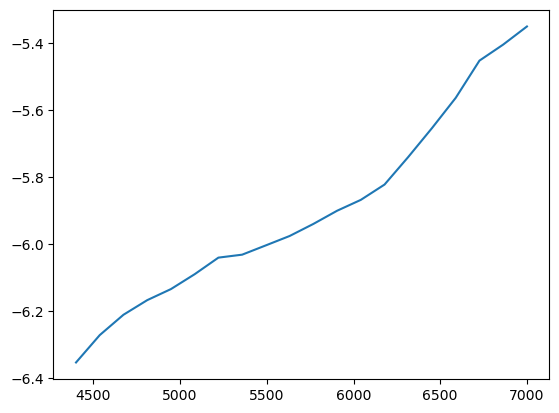

In [29]:
sn = SNModel(4.5)
# sn.bandmag_one(5000.)
# wf
wls = numpy.linspace(4400,7000,20)
mag =[ sn.bandmag_one(wl) for wl in wls]
plt.plot(wls,mag)

In [30]:
@jit
def CCM_a(wl):
    def infrared(x):
        a = 0.574*x**1.61
        return a

    def optical(x):
        y=x-1.82
        a = 1 + 0.17699*y - 0.50447*y**2 - 0.02427*y**3 + 0.72085*y**4+ 0.01979*y**5 - 0.77530*y**6 + 0.32999*y**7
        return a

    def ultraviolet(x):
        a = 1.752 - 0.316*x - 0.104/((x - 4.67)**2 + 0.341)
        return a
        
    x = 1e4/wl
    return jnp.select(condlist=[(x >= 0.3) & (x<=1.1), (x >= 1.1) & (x<=3.3), (x >= 3.3) & (x<=5.9)],
                                choicelist=[infrared(x), optical(x), ultraviolet(x)], default=0.)
def CCM_a_multi(wl):
    return vmap(CCM_a,(0))(wl)

In [31]:
@jit
def CCM_b(wl):
    def infrared(x):
        b = -0.527*x**1.61
        return b

    def optical(x):
        y=x-1.82
        b = 1.41338*y + 2.28305*y**2 + 1.07233*y**3 - 5.38434*y**4 - 0.62251*y**5 + 5.30260*y**6 - 2.09002*y**7
        return b

    def ultraviolet(x):
        b = -3.090 + 1.825*x + 1.206/((x - 4.62)**2 + 0.263)
        return b
        
    x = 1e4/wl
    return jnp.select(condlist=[(x >= 0.3) & (x<=1.1), (x >= 1.1) & (x<=3.3), (x >= 3.3) & (x<=5.9)],
                                choicelist=[infrared(x), optical(x), ultraviolet(x)], default=0.)

def CCM_b_multi(wl):
    return vmap(CCM_b,(0))(wl)

In [32]:
def color(wl, Av, Rv):
    # in dm/dlnl
    # return grad(lambda x: M_sn(x)+Av*(CCM_a(x)+CCM_b(x)/Rv), (0))(wl)/wl
    return grad(lambda x: sn.bandmag_one(x)+Av*(CCM_a(x)+CCM_b(x)/Rv), (0))(wl)/wl

def color_run():
    print (color(4400., 0.1, 3.1))

# color_run()

In [33]:
# distribution of Av Exponentially modified Gaussian distribution

# Reasonable values in wikipedia notation
Avmu = 0.
Avlambda = 5.
Avsigma = 0.15

# in scipy
AvK = 1./Avlambda/Avsigma
Avscale = Avsigma

def pAvrvs(size=1):
    return  exponnorm.rvs(size=size, K=AvK, loc=0, scale=Avscale)
    
def d2lnpAv(x):
    # d2 ln efrc((mu + lambda sigma^2 - x)/sqrt2/sigma)
    # z = (mu + lambda sigma^2 - x)/sqrt2/sigma
    # d1 = 1/erfc(z) (-2/sqrt(pi) exp(-z^2) (-1/sqrt2/sigma)
    # d2 = 
    z = (Avmu + Avlambda*Avsigma*Avsigma - x)/numpy.sqrt(2)/Avsigma
    erfc_ = scipy.special.erfc(z)
    exp_ = numpy.exp(-z**2)
    return 4*exp_/numpy.sqrt(numpy.pi)/Avscale/Avscale/erfc_ * (z - exp_/numpy.sqrt(numpy.pi)/erfc_)

## Chi-sq term (not including dm_int term which is another part of the code)

In [34]:
# For one object one band
def mbar_perfilt(Omega_c, w0, wa, dC, Av, Rv, z, efflam):
    # mu not efficient
    cosmo = jc.Planck15(Omega_c=Omega_c, w0=w0, wa=wa)
    restlam=(efflam+dC[0])/(1+z)
    
    # mu = M_sn(restlam) + 10*jnp.log10(1+z) + 5*jnp.log10(jc.background.angular_diameter_distance(cosmo, 1/(1+z)))[0]
    mu = sn.bandmag_one(restlam) + 10*jnp.log10(1+z) + 5*jnp.log10(jc.background.angular_diameter_distance(cosmo, 1/(1+z)))[0]
    # extiction
    A = Av * (CCM_a(restlam)+CCM_b(restlam)/Rv)

    # SN color
    c = color(restlam, Av, Rv)
    
    # calibration
    return mu + A + dC[1]+ dC[2]*c

def dmbar_perfilt(Omega_c, w0, wa, dC, Av, Rv, z, efflam):
    return grad(mbar_perfilt,(0,1,2,3,4,5))(Omega_c, w0, wa, dC, Av, Rv, z, efflam)

def dmbar(Omega_c, w0, wa, dCs, Av, Rv, z, efflams):
    return vmap(dmbar_perfilt, (None, None, None, 0,  None, None, None, 0))(Omega_c, w0, wa, dCs, Av, Rv, z, efflams)
    

def mbar(Omega_c, w0, wa, dCs, Av, Rv, z, efflams):
    return vmap(mbar_perfilt, (None, None, None, 0,  None, None, None, 0))(Omega_c, w0, wa, dCs, Av, Rv, z, efflams)

def mbar_check():
    nsn=10
    efflams = numpy.array([4700., 6420.,  7849.])
    zs = numpy.linspace(0.1,1,nsn)
    Avs = pAV().rvs(size=nsn, scale=AVscale)
    Rvs = numpy.zeros(nsn)+3.1
    dCs= numpy.zeros((3,3))
    Omega_c=0.3
    w0=-1.
    wa=0.
    # ans = mbar_perfilt(Omega_c, w0, wa,dCs[0],Avs[0],Rvs[0],zs[0],efflams[0])
    # dans = dmbar_perfilt(Omega_c, w0, wa ,dCs[0],Avs[0],Rvs[0],zs[0],efflams[0])
    # print(ans)
    # for _ in dans:
    #     print(_)
    ans = mbar(Omega_c, w0, wa,dCs,Avs[0],Rvs[0],zs[0],efflams)
    dans = dmbar(Omega_c, w0, wa ,dCs,Avs[0],Rvs[0],zs[0],efflams)
    # print(ans)
    for _ in dans:
        print(_)

def F_chisq(Omega_c, w0, wa, dCs, Avs, Rvs, zs, efflams, dm_int, dm_data):

    nfilt = len(efflams)
    nsn = len(Avs)
    ncal = 3
    ncosmo = 3
    npars = 3 + ncal*nfilt + 2*nsn  # 3 cosmology, ncal * nfilt, Av, Rv
                       
    F=numpy.zeros((npars,npars))

    # For now assume all data have same incertainties
    cov = numpy.zeros((nfilt,nfilt))+dm_int**2
    diag = numpy.identity(nfilt) * dm_data**2
    cov = cov + diag
    # Despite the documentation, the example shows L.T L = cov
    L, lower = jsp.linalg.cho_factor(cov)
    
    # loop over SNe
    snind=0
    for Av , Rv, z in zip( Avs, Rvs, zs):
        dmbars = dmbar(Omega_c, w0, wa, dCs, Av, Rv, z, efflams)
        #Cosmo
        for i in range(ncosmo):
            rhs = jsp.linalg.solve_triangular(L, dmbars[i],trans=1,lower=lower)
            F[i,i] += jnp.dot(rhs,rhs)
            #Cosmo
            for j in range(i+1,ncosmo):
                lhs = jsp.linalg.solve_triangular(L, dmbars[j],trans=1,lower=lower)
                F[i,j] += jnp.dot(lhs,rhs)
            # Calibrations
            for j in range(nfilt):
                for k in range(ncal):
                    partial = numpy.zeros(nfilt)
                    partial[j] = dmbars[ncosmo][j][k]
                    lhs = jsp.linalg.solve_triangular(L, partial,trans=1,lower=lower)
                    F[i,ncosmo+ncal*j+k] += jnp.dot(lhs,rhs)
            # Av
            lhs = jsp.linalg.solve_triangular(L, dmbars[ncosmo+1],trans=1,lower=lower)
            F[i,ncosmo+ncal*nfilt+snind] += jnp.dot(lhs,rhs)
            
            # Rv
            lhs = jsp.linalg.solve_triangular(L, dmbars[ncosmo+2],trans=1,lower=lower)
            F[i,ncosmo+ncal*nfilt+nsn+snind] += jnp.dot(lhs,rhs)
        
        #Calibrations
        for i in range(nfilt):
            for l in range(ncal):
                partial = numpy.zeros(nfilt)
                partial[i] = dmbars[ncosmo][i][l]
                rhs = jsp.linalg.solve_triangular(L, partial,trans=1,lower=lower)
                F[ncosmo+ncal*i+l,ncosmo+ncal*i+l] += jnp.dot(rhs,rhs)
                
                # Calibrations
                for j in range(i,nfilt):
                    for k in range(ncal):
                        partial = numpy.zeros(nfilt)
                        partial[j] = dmbars[ncosmo][j][k]
                        lhs = jsp.linalg.solve_triangular(L, partial,trans=1,lower=lower)
                        F[ncosmo+ncal*i+l,ncosmo+ncal*j+k] += jnp.dot(lhs,rhs)
                # Av
                lhs = jsp.linalg.solve_triangular(L, dmbars[ncosmo+1],trans=1,lower=lower)
                F[ncosmo+ncal*i+l,ncosmo+ncal*nfilt+snind] += jnp.dot(lhs,rhs)
                
                # Rv
                lhs = jsp.linalg.solve_triangular(L, dmbars[ncosmo+2],trans=1,lower=lower)
                F[ncosmo+ncal*i+l,ncosmo+ncal*nfilt+nsn+snind] += jnp.dot(lhs,rhs)
        

        #Av
        rhs = jsp.linalg.solve_triangular(L, dmbars[ncosmo+1],trans=1,lower=lower)
        F[ncosmo+ncal*nfilt+snind, ncosmo+ncal*nfilt+snind] += jnp.dot(rhs,rhs)

            #Rv
        lhs = jsp.linalg.solve_triangular(L, dmbars[ncosmo+2],trans=1,lower=lower)
        F[ncosmo+ncal*nfilt+snind, ncosmo+ncal*nfilt+nsn+snind] += jnp.dot(lhs,rhs)

        #Rv
        F[ncosmo+ncal*nfilt+nsn+snind,ncosmo+ncal*nfilt+nsn+snind] += jnp.dot(lhs,lhs)
        
        snind+=1

    for i in range(npars):
        for j in range(i+1,npars):
            F[j,i]=F[i,j]

    return F
        
def F_chisq_check():
    ncal=3
    nsn=10
    efflams = numpy.array([4700., 6420.,  7849.])
    zs = numpy.linspace(0.1,1,nsn)
    Avs = pAV().rvs(size=nsn, scale=AVscale)
    Rvs = numpy.zeros(nsn)+3.1
    dCs= numpy.zeros((3,ncal))
    Omega_c=0.3
    w0=-1.
    wa=0.
    dm_int=0.1
    dm_data=0.02
    F = F_chisq(Omega_c, w0, wa, dCs, Avs, Rvs, zs, efflams, dm_int, dm_data)
    print(F)

## Chi-sq term for dm_int (Not implemented correctly)

In [35]:
def lnL_dm_int(dm_int, dm_data, nfilt):
    
    # For now assume all data have same incertainties
    cov = numpy.zeros((nfilt,nfilt))+dm_int**2
    diag = numpy.identity(nfilt) * dm_data**2
    cov = cov + diag
    # Despite the documentation, the example shows L.T L = cov
    L, lower = jsp.linalg.cho_factor(cov)    
    return -0.5/jnp.diagonal(L).prod()**2

def d2ln_dm_int(dm_int, dm_data, nfilt):
    return grad(grad(lnL_dm_int,(0)),(0))(dm_int,dm_data, nfilt)

def F_chisq_dm_int(efflams, dm_int, dm_data, nsn):
    nfilt = len(efflams)

## A term

In [36]:
def F_Av(Avs):
    ans = []
    for Av in Avs:
        ans.append(-d2lnpAv(Av))
    return ans

def F_Av_test():
    nsn=10
    Avs = pAv().rvs(size=nsn, scale=Avscale)    
    print(Avs, F_Av(Avs))

# F_Av_test()

## Log det term

In [37]:
def lnL_logdet(dm_int, dm_data, efflams):
    nfilt=len(efflams)
    # For now assume all data have same incertainties
    cov = numpy.zeros((nfilt,nfilt))+dm_int**2
    diag = numpy.identity(nfilt) * dm_data**2
    cov = cov + diag
    # Despite the documentation, the example shows L.T L = cov
    L, lower = jsp.linalg.cho_factor(cov)

    # logdet term
    ans = - jnp.log(jnp.diagonal(L)).sum()
    return ans

def F_logdet(dm_int, dm_data, efflams):
    return grad(grad(lnL_logdet,(0)),(0))(dm_int, dm_data, efflams)

def F_logdet_check():
    dm_int=0.1
    dm_data=0.02
    efflams = numpy.array([4700., 6420.,  7849.])
    print(F_logdet(dm_int, dm_data, efflams))

## Combining all contributions to F (for now leaving out dm_int)

In [38]:
def F_all(Omega_c, w0, wa, dCs, Avs, Rvs, zs, efflams, dm_int, dm_data):

    nsn = len(Avs)
    # prior uncertainty in the calibration parameters
    ncal=3
    ncosmo =3
    ncalinvsig2 = [1.,1e4, 1e12]
    # lnlam = numpy.log(efflams)
    # deltalnlam = (lnlam[-1] - lnlam[0])/(nfilt-1)
    # print(deltalnlam)
    # wef
    
    nfilt = len(efflams)
    
    # chisq term fills everything
    F = F_chisq(Omega_c, w0, wa, dCs, Avs, Rvs, zs, efflams, dm_int, dm_data)

    # by hand put in priors for calibration
    for i in range(nfilt):
        for j in range(ncal):
            F[ncosmo+i*nfilt+j,ncosmo+i*nfilt+j] += ncalinvsig2[j]
    
    Favs = F_Av(Avs)
    for i in range(nsn):
        F[ncosmo+ncal*nfilt+i, ncosmo+ncal*nfilt+i]+=Favs[i]

    for i in range(nsn):
        F[ncosmo+ncal*nfilt+nsn+i, ncosmo+ncal*nfilt+nsn+i]+= 1/0.3**3  # by hand the underlying distribution of Rv

    return F

## Properties of the DES filter system

In [39]:
efflams = numpy.array([4700., 6420.,  7849.])
ffwhm = numpy.array([1500., 1480.,  1470.])
nfilt=len(efflams)
# separation between filters in log-lambda
lnlam = numpy.log(efflams)
deltalnlam = (lnlam[-1] - lnlam[0])/(nfilt-1)
print(deltalnlam)

# lambda/Delta lambda
print (efflams/ffwhm)

delta = numpy.arcsinh(1/2/4.5)
print(efflams*(numpy.exp(delta)-numpy.exp(-delta)))

0.25641181321433226
[3.13333333 4.33783784 5.33945578]
[1044.44444444 1426.66666667 1744.22222222]


## Run a real example

In [40]:
cosmo = jc.Planck15()
Omega_c=cosmo.Omega_c
w0=cosmo.w0
wa=cosmo.wa
dm_int =0.1
ncal=3
ncosmo=3
efflams = numpy.array([4700., 6420.,  7849.])
ffwhm = numpy.array([1500., 1480.,  1470.])
nfilt=len(efflams)

#survey 1
nsn=100
dm_data =0.02
zs = numpy.linspace(0.3,1,nsn)
zs = numpy.linspace(0.3**3,1**3,nsn)
zs = zs**(1/3)

Avs = pAvrvs(size=nsn)
Rvs = numpy.zeros(nsn)+3.1
dCs= numpy.zeros((3,ncal))

F1 =  F_all(Omega_c, w0, wa, dCs, Avs, Rvs, zs, efflams, dm_int, dm_data)

# #survey 2
nsn=100
dm_data =0.02
zs = numpy.linspace(0.01**3,0.1**3,nsn)
zs = zs**(1/3)

Avs = pAvrvs(size=nsn)
Rvs = numpy.zeros(nsn)+3.1
dCs= numpy.zeros((3,ncal))

F2 =  F_all(Omega_c, w0, wa, dCs, Avs, Rvs, zs, efflams, dm_int, dm_data)

npars = ncosmo + 2*(ncal*nfilt + 2*nsn )

F = numpy.zeros((npars,npars))
F[0:ncosmo, 0:ncosmo] = F1[0:ncosmo, 0:ncosmo]+ F2[0:ncosmo, 0:ncosmo]
F[0:ncosmo, ncosmo:ncosmo+ncal*nfilt + 2*len(Avs)] = F1[0:ncosmo,ncosmo:]
F[0:ncosmo, ncosmo+ncal*nfilt + 2* len(Avs):] = F2[0:ncosmo,ncosmo:]
F[ncosmo:ncosmo+ncal*nfilt + 2* len(Avs),0:ncosmo] = F1[ncosmo:,0:ncosmo]
F[ncosmo+ncal*nfilt + 2* len(Avs):,0:ncosmo] = F2[ncosmo:,0:ncosmo]
F[ncosmo:ncosmo+ncal*nfilt + 2* len(Avs),ncosmo:ncosmo+ncal*nfilt + 2* len(Avs)] = F1[ncosmo:,ncosmo:]
F[ncosmo+ncal*nfilt + 2*len(Avs):, ncosmo+ncal*nfilt + 2*len(Avs):] = F2[ncosmo:,ncosmo:]

F[0,0] += 1/0.03**2 # Omega_M prior

print(numpy.linalg.slogdet(F))
Finv= numpy.linalg.inv(F[0:3,0:3])
print(Finv[0:ncosmo,0:ncosmo])


(1.0, 2351.452730562149)
[[ 0.00089364 -0.00099394 -0.00915035]
 [-0.00099394  0.01539966 -0.08063864]
 [-0.00915035 -0.08063864  0.69774149]]


In [ ]:
numpy.sqrt(0.0008)

In [ ]:
numpy.sqrt(8.98e-4)